In [1]:
%precision 3
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

In [2]:
def pressure_poisson_jacobi(p, dx, dy, RHS, rtol = 1.e-5, logs = False):
    """ Solve the pressure Poisson equation (PPE)
    using Jacobi iteration assuming mesh spacing of
    dx and dy (we assume at the moment that dx=dy)
    and the RHS function given by RHS.
    
    Assumes imposition of a Neumann BC on all boundaries.
    
    Return the pressure field.
    """
    # iterate
    tol = 10.*rtol
    it = 0
    p_old = np.copy(p)
    
    imax = len(p)
    jmax = np.size(p)//imax
    
    while tol > rtol:
        it += 1
        #this version is valid for dx!=dy
        p[1:-1, 1:-1] = 1.0/(2.0+2.0*(dx**2)/(dy**2))*(p_old[2:, 1:-1] + p_old[:-2, 1:-1] +
                                (p_old[1:-1, 2:] + p_old[1:-1,:-2])*(dx**2)/(dy**2)
                                - (dx**2)*RHS[1:-1, 1:-1])
        
        # apply zero gradient Neumann boundary conditions at the no slip walls
        p[:, 0] = p[:, 1]
        p[:, -1] = p[:, -2]
        p[0, :-(jmax-jmax//2)] = p[1, :-(jmax-jmax//2)]

        # relative change in pressure
        tol = sl.norm(p - p_old)/np.maximum(1.0e-10,sl.norm(p))
        
        #swap arrays without copying the data
        temp = p_old
        p_old = p
        p = temp
        
    if logs: print('pressure solve iterations = {:4d}'.format(it))
    return p

In [3]:
def calculate_ppm_RHS_upwind(rho, u, v, RHS, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use upwind differences for the first derivatives of u and v.
    """
    RHS[1:-1, 1:-1] =rho*(np.select([u[1:-1, 1:-1] > 0, u[1:-1, 1:-1] <= 0],
                      [np.diff(u[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(u[1:, 1:-1], n=1, axis=0)/dx]) + 
              np.select([v[1:-1, 1:-1] > 0, v[1:-1, 1:-1] <= 0],
                      [np.diff(v[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(v[1:-1, 1:], n=1, axis=1)/dy]))
    return RHS

def calculate_ppm_RHS_central(rho, u, v, RHS, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use central differences for the first derivatives of u and v.
    """
    RHS[1:-1, 1:-1] = rho * (
        (1.0/dt) * ( (u[2:, 1:-1] - u[:-2, 1:-1]) / (2.0*dx) 
                   + (v[1:-1, 2:] - v[1:-1, :-2]) / (2.0*dy) ))
    return RHS

def project_velocity(rho, u, v, dt, dx, dy, p):
    """ Update the velocity to be divergence free using the pressure.
    """
    u[1:-1, 1:-1] = u[1:-1, 1:-1] - dt * (1./rho) * (
        (p[2:, 1:-1] - p[:-2, 1:-1])/(2*dx) )
    v[1:-1, 1:-1] = v[1:-1, 1:-1] - dt * (1./rho) * (
        (p[1:-1, 2:] - p[1:-1, :-2])/(2*dy) )

    return u, v

def calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy):
    """ Calculate the intermediate velocities.
    """
    # intermediate u
    u[1:-1, 1:-1] = u_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uu_x + vu_x
                        u_old[1:-1, 1:-1] *
                      # see comments in the upwind based solver for advection above
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(u_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(u_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                         dt*nu*(np.diff(u_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(u_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    # intermediate v
    v[1:-1, 1:-1] = v_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uv_x + vv_x
                        u_old[1:-1, 1:-1] *
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(v_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(v_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                        dt*nu*(np.diff(v_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(v_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    
    #apply the velocity boundary condition to the intermediate velocity data
    #apply the velocity boundary condition
    imax = len(u)
    jmax = np.size(u)//imax
    u[0, jmax//2:] = u[1,jmax//2:]
    u[-1,:] = u[-2,:]
    
    return u, v

In [4]:
def solve_NS(u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol = 1.e-5, logs = False, outint = 100):
    """ Solve the incompressible Navier-Stokes equations
    using a lot of the numerical choices and approaches we've seen
    earlier in this lecture.
    """
    t = 0
    
    u_old = u.copy()
    v_old = v.copy()
    p_RHS = np.zeros_like(X)
    
    time_it = 0 
    
    while t < t_end:
        time_it+=1
        #set dt based on courant number
        vel_max = np.max(np.sqrt(u**2+v**2))
        if vel_max>0.0:
            dt = min(courant*min(dx,dy)/vel_max,dt_min)
        else:
            dt = dt_min
            
        t += dt
        if logs and time_it%outint == 0: 
            print('\nTime = {:.8f}'.format(t))
            
        # calculate intermediate velocities
        u, v = calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy)
        # PPM
        # calculate RHS for the pressure Poisson problem
        p_RHS = calculate_ppm_RHS_central(rho, u, v, p_RHS, dt, dx, dy)
        # compute pressure - note that we use the previous p as an initial guess to the solution
        p = pressure_poisson_jacobi(p, dx, dy, p_RHS, 1.e-5, logs = (logs and time_it%outint == 0))
        # project velocity
        u, v = project_velocity(rho, u, v, dt, dx, dy, p)
        
        if logs and time_it%outint == 0:
            print('norm(u) = {0:.8f}, norm(v) = {1:.8f}'.format(sl.norm(u),sl.norm(v)))
            print('Courant number: {0:.8f}'.format(np.max(np.sqrt(u**2+v**2)) * dt / min(dx,dy)))
                
        #swap pointers without copying data
        temp = u_old
        u_old = u
        u = temp
        temp = v_old
        v_old = v
        v = temp
    return u, v, p

In [5]:
# physical parameters
rho = 1
nu = 1./10.

# define spatial mesh
# Size of rectangular domain
Lx = 4.0
Ly = 1.0

P_max = 0.5

# Number of grid points in each direction, including boundary nodes
Nx = 201
Ny = 51

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(p)
jmax = np.size(p)//imax
p[0, (jmax//2):] = P_max
p[-1, :] = 0.0

#set a Courant number and use dynamic time step
courant = 0.005
dt_min = 1.e-3

t_end = 10.0

import time
start = time.time()
u, v, p = solve_NS(u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs = True, outint = 1000)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 0.92504142
pressure solve iterations =    9
norm(u) = 5.75588435, norm(v) = 0.82023177
Courant number: 0.00500413

Time = 1.56396603
pressure solve iterations =    4
norm(u) = 7.17385750, norm(v) = 1.01437241
Courant number: 0.00500118

Time = 2.12247992
pressure solve iterations =    2
norm(u) = 7.75132786, norm(v) = 1.09305978
Courant number: 0.00500050

Time = 2.65200717
pressure solve iterations =    2
norm(u) = 8.02592629, norm(v) = 1.13039598
Courant number: 0.00500024

Time = 3.16846933
pressure solve iterations =    1
norm(u) = 8.16407065, norm(v) = 1.14915841
Courant number: 0.00500012

Time = 3.67852842
pressure solve iterations =    1
norm(u) = 8.23535741, norm(v) = 1.15883487
Courant number: 0.00500006

Time = 4.18532702
pressure solve iterations =    1
norm(u) = 8.27260476, norm(v) = 1.16388939
Courant number: 0.00500003

Time = 4.69043372
pressure solve iterations =    1
norm(u) = 8.29219033, norm(v) = 1.16654680
Courant number: 0.00500002

Time = 5.19465397
press

Text(0.5, 1.0, 'Pressure driven problem - speed')

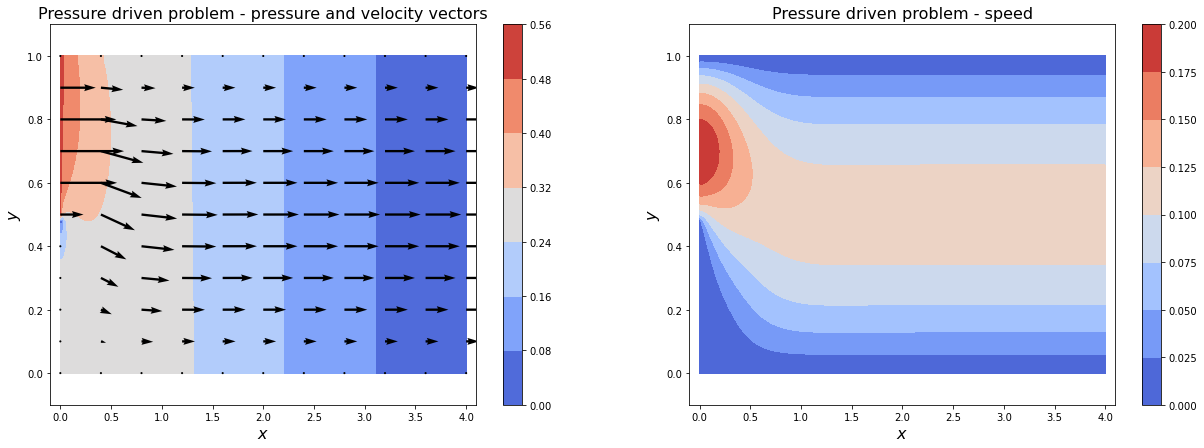

In [6]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,p, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::20,::5],Y[::20,::5],u[::20,::5],v[::20,::5])
ax1.set_xlim(-0.1, 4.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - pressure and velocity vectors', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.1, 4.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - speed', fontsize=16)

In [7]:
flow_in = np.sum(u[0,:])*Ly
flow_out = np.sum(u[-1,:])*Ly

print('flow in ',flow_in)
print('flow out ',flow_out)

flow in  3.6400883324252575
flow out  3.6920762379752325


In [8]:
# physical parameters
rho = 1
nu = 1./10.

# define spatial mesh
# Size of rectangular domain
Lx = 4.0
Ly = 1.0

P_max = 5.0

# Number of grid points in each direction, including boundary nodes
Nx = 201
Ny = 51

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(p)
jmax = np.size(p)//imax
p[0, (jmax//2):] = P_max
p[-1, :] = 0.0

#set a Courant number and use dynamic time step
courant = 0.005
dt_min = 1.e-3

t_end = 10.0

import time
start = time.time()
u, v, p = solve_NS(u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs = True, outint = 1000)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 0.29128222
pressure solve iterations =    4
norm(u) = 26.40120295, norm(v) = 3.82856151
Courant number: 0.00500452

Time = 0.42434206
pressure solve iterations =    2
norm(u) = 35.59942847, norm(v) = 5.05105750
Courant number: 0.00500213

Time = 0.53042189
pressure solve iterations =    3
norm(u) = 42.01154659, norm(v) = 5.87103940
Courant number: 0.00500135

Time = 0.62274982
pressure solve iterations =    2
norm(u) = 47.02031125, norm(v) = 6.49357974
Courant number: 0.00500097

Time = 0.70638201
pressure solve iterations =    1
norm(u) = 51.15035533, norm(v) = 6.99497900
Courant number: 0.00500075

Time = 0.78389566
pressure solve iterations =    2
norm(u) = 54.66746928, norm(v) = 7.41343505
Courant number: 0.00500061

Time = 0.85681524
pressure solve iterations =    1
norm(u) = 57.72801356, norm(v) = 7.77118401
Courant number: 0.00500050

Time = 0.92613075
pressure solve iterations =    1
norm(u) = 60.43299488, norm(v) = 8.08241933
Courant number: 0.00500043

Time = 0.992527


Time = 3.75704645
pressure solve iterations =    1
norm(u) = 97.58845531, norm(v) = 11.95233037
Courant number: 0.00500001

Time = 3.79862049
pressure solve iterations =    2
norm(u) = 97.70715402, norm(v) = 11.96381350
Courant number: 0.00500001

Time = 3.84014400
pressure solve iterations =    2
norm(u) = 97.82156782, norm(v) = 11.97487896
Courant number: 0.00500001

Time = 3.88161893
pressure solve iterations =    2
norm(u) = 97.93186337, norm(v) = 11.98554319
Courant number: 0.00500001

Time = 3.92304712
pressure solve iterations =    2
norm(u) = 98.03820000, norm(v) = 11.99582194
Courant number: 0.00500001

Time = 3.96443035
pressure solve iterations =    1
norm(u) = 98.14073009, norm(v) = 12.00573025
Courant number: 0.00500001

Time = 4.00577032
pressure solve iterations =    1
norm(u) = 98.23959943, norm(v) = 12.01528246
Courant number: 0.00500001

Time = 4.04706866
pressure solve iterations =    2
norm(u) = 98.33494755, norm(v) = 12.02449234
Courant number: 0.00500001

Time = 


Time = 6.44443388
pressure solve iterations =    1
norm(u) = 100.65879900, norm(v) = 12.24832880
Courant number: 0.00500000

Time = 6.48473826
pressure solve iterations =    1
norm(u) = 100.67062459, norm(v) = 12.24946486
Courant number: 0.00500000

Time = 6.52503789
pressure solve iterations =    2
norm(u) = 100.68205405, norm(v) = 12.25056283
Courant number: 0.00500000

Time = 6.56533294
pressure solve iterations =    1
norm(u) = 100.69310076, norm(v) = 12.25162401
Courant number: 0.00500000

Time = 6.60562357
pressure solve iterations =    2
norm(u) = 100.70377765, norm(v) = 12.25264964
Courant number: 0.00500000

Time = 6.64590991
pressure solve iterations =    1
norm(u) = 100.71409719, norm(v) = 12.25364092
Courant number: 0.00500000

Time = 6.68619211
pressure solve iterations =    1
norm(u) = 100.72407143, norm(v) = 12.25459900
Courant number: 0.00500000

Time = 6.72647031
pressure solve iterations =    2
norm(u) = 100.73371201, norm(v) = 12.25552502
Courant number: 0.00500000



Time = 9.09896232
pressure solve iterations =    1
norm(u) = 100.97532247, norm(v) = 12.27872633
Courant number: 0.00500000

Time = 9.13914008
pressure solve iterations =    1
norm(u) = 100.97658511, norm(v) = 12.27884754
Courant number: 0.00500000

Time = 9.17931734
pressure solve iterations =    2
norm(u) = 100.97780577, norm(v) = 12.27896473
Courant number: 0.00500000

Time = 9.21949411
pressure solve iterations =    1
norm(u) = 100.97898586, norm(v) = 12.27907802
Courant number: 0.00500000

Time = 9.25967041
pressure solve iterations =    1
norm(u) = 100.98012673, norm(v) = 12.27918755
Courant number: 0.00500000

Time = 9.29984625
pressure solve iterations =    2
norm(u) = 100.98122967, norm(v) = 12.27929343
Courant number: 0.00500000

Time = 9.34002165
pressure solve iterations =    2
norm(u) = 100.98229595, norm(v) = 12.27939579
Courant number: 0.00500000

Time = 9.38019663
pressure solve iterations =    1
norm(u) = 100.98332680, norm(v) = 12.27949476
Courant number: 0.00500000


Text(0.5, 1.0, 'Pressure driven problem - speed')

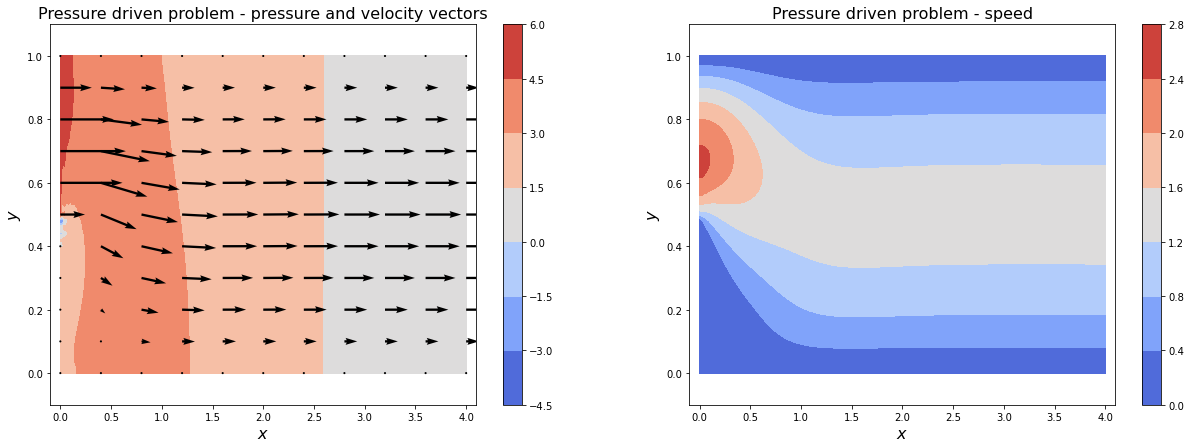

In [9]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,p, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::20,::5],Y[::20,::5],u[::20,::5],v[::20,::5])
ax1.set_xlim(-0.1, 4.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - pressure and velocity vectors', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.1, 4.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - speed', fontsize=16)

In [10]:
flow_in = np.sum(u[0,:])*Ly
flow_out = np.sum(u[-1,:])*Ly

print('flow in ',flow_in)
print('flow out ',flow_out)

flow in  44.11691653247884
flow out  44.30906374017106
